## Manual testing.

This notebook serves as an integration test to confirm that the model is behaving as we expect.

In [1]:
import sys
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
MODEL_DIR = os.path.realpath(os.path.dirname('../superscript_model'))
sys.path.append(os.path.normpath(MODEL_DIR))

In [3]:
from superscript_model import model
from superscript_model.utilities import Random

In [4]:
abm = model.SuperScriptModel(
    worker_count=1000,
    new_projects_per_timestep=20,
    organisation_strategy='Random',
    worker_strategy='AllIn',
    save_network='False'
)

In [5]:
steps = range(20)
active_projects = []
team_size = []

elapsed_times = []

for step in steps:
    
    start_time = time.time()
    abm.step()
    elapsed_time = time.time() - start_time  
    print("Step %d took %.2f seconds" % (step, elapsed_time))
    elapsed_times.append(elapsed_time)
    
    size = 0
    active_projects.append(abm.inventory.active_count)
    
    for project in abm.inventory.projects.values():
        size += len(project.team.members)
    team_size.append(size/len(abm.inventory.projects.values()))

Step 0 took 0.10 seconds
Step 1 took 0.08 seconds
Step 2 took 0.09 seconds
Step 3 took 0.09 seconds
Step 4 took 0.14 seconds
Step 5 took 0.11 seconds
Step 6 took 0.10 seconds
Step 7 took 0.09 seconds
Step 8 took 0.11 seconds
Step 9 took 0.11 seconds
Step 10 took 0.10 seconds
Step 11 took 0.12 seconds
Step 12 took 0.10 seconds
Step 13 took 0.11 seconds
Step 14 took 0.10 seconds
Step 15 took 0.11 seconds
Step 16 took 0.15 seconds
Step 17 took 0.13 seconds
Step 18 took 0.10 seconds
Step 19 took 0.12 seconds


In [8]:
print(np.mean(elapsed_times))

0.39133926630020144


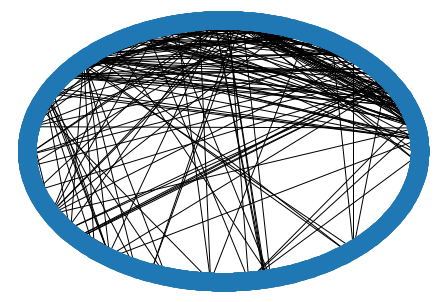

In [9]:
nx.draw(abm.grid.G, pos=nx.circular_layout(abm.grid.G))

In [10]:
#abm.grid.G.nodes(0)

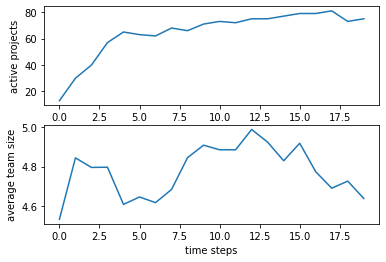

In [11]:
plt.subplot(2,1,1)
plt.plot(steps, active_projects)
plt.ylabel('active projects')

plt.subplot(2,1,2)
plt.plot(steps, team_size)
plt.xlabel('time steps')
plt.ylabel('average team size');

In [18]:
print(np.mean(active_projects))
print(np.mean(team_size))

64.7
4.776720775721676


#### We now select a random worker from the model and inspect the worker:

This produces a json formatted text summary of the worker. Note that this representation will be updated when we add in the worker's history and project activities.

In [13]:
random_worker = Random.choice(abm.schedule.agents)

print(random_worker.skills.to_string())

{
    "Worker OVR": 36.3,
    "Hard skills": [
        1.3,
        1.5,
        2.6,
        0.8,
        2.9
    ],
    "Soft skills": [
        2.3,
        3.5,
        4.3,
        2.3,
        1.4
    ],
    "Hard skill probability": 0.8,
    "OVR multiplier": 20
}


#### We now do the same for a randomly selected project..

In [14]:
random_project = Random.choice(list(abm.inventory.projects.values()))

In [15]:
print(random_project.requirements.to_string())

{
    "risk": 25,
    "creativity": 5,
    "flexible_budget": true,
    "budget": 50.0,
    "p_hard_skill_required": 0.8,
    "min_skill_required": 2,
    "per_skill_cap": 7,
    "total_skill_units": 17,
    "hard_skills": {
        "A": {
            "level": 4,
            "units": 3
        },
        "B": {
            "level": null,
            "units": 0
        },
        "C": {
            "level": 2,
            "units": 7
        },
        "D": {
            "level": 2,
            "units": 7
        },
        "E": {
            "level": null,
            "units": 0
        }
    }
}


#### For this project we can also inspect the Team:

In [17]:
print(random_project.team.to_string())

{
    "project": 325,
    "members": [
        757,
        1130,
        1269,
        1473,
        1149
    ],
    "lead": 1149,
    "success_probability": 0,
    "team_ovr": 19.5,
    "skill_balance": 1.8,
    "creativity_match": 2.1,
    "skill_contributions": {
        "A": [
            1473,
            757,
            1130
        ],
        "C": [
            1473,
            1149,
            757,
            1130,
            1269
        ],
        "D": [
            1269,
            1149,
            1473,
            757,
            1130
        ]
    }
}


#### Note that allocating the total skill units across the skills in a robust way was a non-trivial problem! Solved as follows...

*(Move this to another notebook).*

Select 5 numbers in (1,10) that sum to X, where X <=50
Always a = max(a,1) and b = min(b,10)
-	Select n1 randint(a,b) where a = X – (4\*10) and b = X – (4\*1)
-	Select n2 randint(a,b) where a = X – n1 – (3\*10) and b = X – n1 – (3\*1)
-	Select n3 randint(a,b) where a = X – n1 – n2 – (2\*10) and b = X – n1 – n2 – (2\*1)
-	…
-	Select n5 randint(a,b) where a = X – n1 – n2 – n3 – n4 and b = X – n1 – n2 – n3 – n4


In [15]:
def generate_skills(total):

    min_units = 1
    max_units = 10

    remaining = total
    length = 5

    assert total <= length*max_units
    assert total >= length*min_units

    skills = []

    for i in range(length):

        a = remaining - (length - (i+1))*max_units
        a = max(a, min_units)

        b = remaining - (length - (i+1))*min_units
        b = min(b, max_units)

        n = Random.randint(a,b)
        skills.append(n)
        remaining -= n
        
    assert sum(skills) == total
    return skills

In [16]:
for t in np.arange(5,50):
    print(generate_skills(t), "; sum = ", t)

[1, 1, 1, 1, 1] ; sum =  5
[2, 1, 1, 1, 1] ; sum =  6
[1, 2, 2, 1, 1] ; sum =  7
[3, 2, 1, 1, 1] ; sum =  8
[4, 2, 1, 1, 1] ; sum =  9
[5, 1, 1, 2, 1] ; sum =  10
[3, 3, 3, 1, 1] ; sum =  11
[7, 2, 1, 1, 1] ; sum =  12
[7, 3, 1, 1, 1] ; sum =  13
[4, 7, 1, 1, 1] ; sum =  14
[4, 5, 2, 2, 2] ; sum =  15
[6, 5, 1, 1, 3] ; sum =  16
[5, 5, 4, 1, 2] ; sum =  17
[9, 4, 2, 2, 1] ; sum =  18
[10, 2, 3, 1, 3] ; sum =  19
[4, 7, 1, 1, 7] ; sum =  20
[6, 1, 9, 3, 2] ; sum =  21
[9, 7, 4, 1, 1] ; sum =  22
[10, 7, 3, 1, 2] ; sum =  23
[9, 9, 3, 1, 2] ; sum =  24
[4, 4, 5, 7, 5] ; sum =  25
[1, 9, 4, 3, 9] ; sum =  26
[8, 9, 7, 2, 1] ; sum =  27
[7, 8, 4, 6, 3] ; sum =  28
[4, 3, 5, 10, 7] ; sum =  29
[1, 3, 8, 9, 9] ; sum =  30
[1, 8, 6, 6, 10] ; sum =  31
[9, 8, 2, 6, 7] ; sum =  32
[5, 9, 3, 10, 6] ; sum =  33
[1, 9, 8, 6, 10] ; sum =  34
[9, 5, 10, 6, 5] ; sum =  35
[5, 6, 6, 10, 9] ; sum =  36
[7, 10, 3, 9, 8] ; sum =  37
[5, 4, 10, 10, 9] ; sum =  38
[5, 8, 6, 10, 10] ; sum =  39
[4, 10, 7, 9